# XGBoost Tuning (Descriptors + Fingerprints)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)
import xgboost as xgb
from xgboost import XGBClassifier
import shap
import optuna
from mordred import Calculator, descriptors as mordred_descriptors

/home/notebook/Documents/Workspace/Python/TP-Jupyter/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Molecule, Descriptor + Fingerprints and Outlier Functions

In [2]:
# Create calculator once
MORDRED_CALC = Calculator(mordred_descriptors, ignore_3D=True)

def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs (Only critical)
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_descriptors(molecule):
    try:
        # Mordred returns a object
        result = MORDRED_CALC(molecule)

        # Convert to plain dict with string names as keys
        desc_dict = {}
        for name, value in result.items():
            key = str(name)

            # Mordred may return special error/None objects
            if value is None:
                desc_dict[key] = np.nan
                continue

            # Some values are not numeric - keep onlz numeric
            try:
                desc_dict[key] = float(value)
            except Exception:
                desc_dict[key] = np.nan

        return desc_dict

    except Exception as e:
        print(f"Mordred descriptor calc failed: {e}")
        return {}
    

def compute_iqr_limits(df, factor=1.5):
    # Calculate IQR limits
    limits = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat - skip
        if iqr == 0 or np.isnan(iqr):
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        limits[col] = (lower, upper)
    return limits


def apply_iqr_limits(df, limits):
    # Apply the limits
    df_clipped = df.copy()
    for col, (lower, upper) in limits.items():
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped

## Dataset Processing

In [ ]:
# Configuration
ORIG_DATASET = "3d_dataset.xlsx"
SKIP_ROWS = 1
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
FULL_OUTPUT_DATASET = "3d_dataset_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"

# Near constant threshold - tolerance
SIMILARITY_THRESHOLD = 0.90
# Correlation threshold
CORRELATION_THRESHOLD = 0.95

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

# Build descriptors
descriptor_rows = []
state_molecules = []
molecules = []

# Loop over the SMILES column
for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    # If molecule construction failed - empty placeholder
    if molecule is None:
        descriptor_rows.append({})
        continue
    # Calculate descriptors for each molecule
    descriptor_rows.append(calculate_descriptors(molecule))

# Convert list of dictionaries into dataframe
descriptor_data_all = pd.DataFrame(descriptor_rows)

# Keep everything + status
output = pd.concat(
    [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)],
    axis=1
)
output["MoleculeStatus"] = state_molecules

# Output whole dataset with descriptors and state
with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Drop failed molecules - boolean array
molecules_right = []
for molecule in molecules:
    if molecule is not None:
        molecules_right.append(True)
    else:
        molecules_right.append(False)
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Take only numeric descriptor columns
X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
for column in X_full.columns:
    X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)

# Split dataset - train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Calculate medians for each column in train only
train_medians = X_train.median(numeric_only=True)

# Fill missing values in both train and test using those medians
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Compute constants on train only
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

# Drop from train and apply same drop to test
if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

# Compute absolute correlation matrix on training data
corr_matrix = X_train.corr().abs()
# Keep only upper triangle of the matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find columns to drop - correlation
high_corr_cols = []
for col in upper.columns:
    if any(upper[col] > CORRELATION_THRESHOLD):
        high_corr_cols.append(col)

# Drop from both train and test
if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated columns.")

# Compute IQR limits on training data
iqr_limits = compute_iqr_limits(X_train, factor=1.5)

# Apply limits to both train and test sets
X_train = apply_iqr_limits(X_train, iqr_limits)
X_test = apply_iqr_limits(X_test, iqr_limits)

X_train = pd.DataFrame(X_train, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test, columns=X_test.columns, index=X_test.index)

X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
print("First rows of train x:")
print(X_train.head().to_string(index=False))
print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
print("First rows of train y:")
print(y_train.head().to_string(index=False))
X_train.describe()

print("\nTrain set class counts:")
print(y_train.value_counts())
print("\nTrain set class ratio:")
print(y_train.value_counts(normalize=True))

print("\nTest set class counts:")
print(y_test.value_counts())
print("\nTest set class ratio:")
print(y_test.value_counts(normalize=True))

Full - Rows: 35/Columns: 1622
                       Name                                                                                                                                         IUPAC name CAS registry number      Structure  Phototoxicity                                                                             SMILES code                                          Sources  Note  ABC  ABCGG  nAcid  nBase   SpAbs_A  SpMax_A  SpDiam_A    SpAD_A  SpMAD_A  LogEE_A    VE1_A    VE2_A    VE3_A      VR1_A     VR2_A    VR3_A  nAromAtom  nAromBond  nAtom  nHeavyAtom  nSpiro  nBridgehead  nHetero   nH  nB   nC  nN  nO  nS  nP  nF  nCl  nBr  nI  nX     ATS0dv     ATS1dv     ATS2dv     ATS3dv     ATS4dv      ATS5dv      ATS6dv      ATS7dv  ATS8dv  ATS0d  ATS1d  ATS2d  ATS3d  ATS4d  ATS5d  ATS6d  ATS7d  ATS8d      ATS0s      ATS1s      ATS2s      ATS3s      ATS4s      ATS5s      ATS6s      ATS7s      ATS8s  ATS0Z  ATS1Z  ATS2Z  ATS3Z  ATS4Z  ATS5Z  ATS6Z  ATS7Z  ATS8Z       ATS0m    

## Base Model Train

In [4]:
base_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42
)
# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nModel performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Model performance:
Accuracy:  0.1429
Precision: 0.2500
Recall:    0.2500
F1 score:  0.2500
ROC AUC:   0.0000

Classification report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         3
           1      0.250     0.250     0.250         4

    accuracy                          0.143         7
   macro avg      0.125     0.125     0.125         7
weighted avg      0.143     0.143     0.143         7



## Feature Selection

PermutationExplainer explainer: 29it [00:11,  1.64s/it]                        
/tmp/ipykernel_68989/582230141.py:38: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


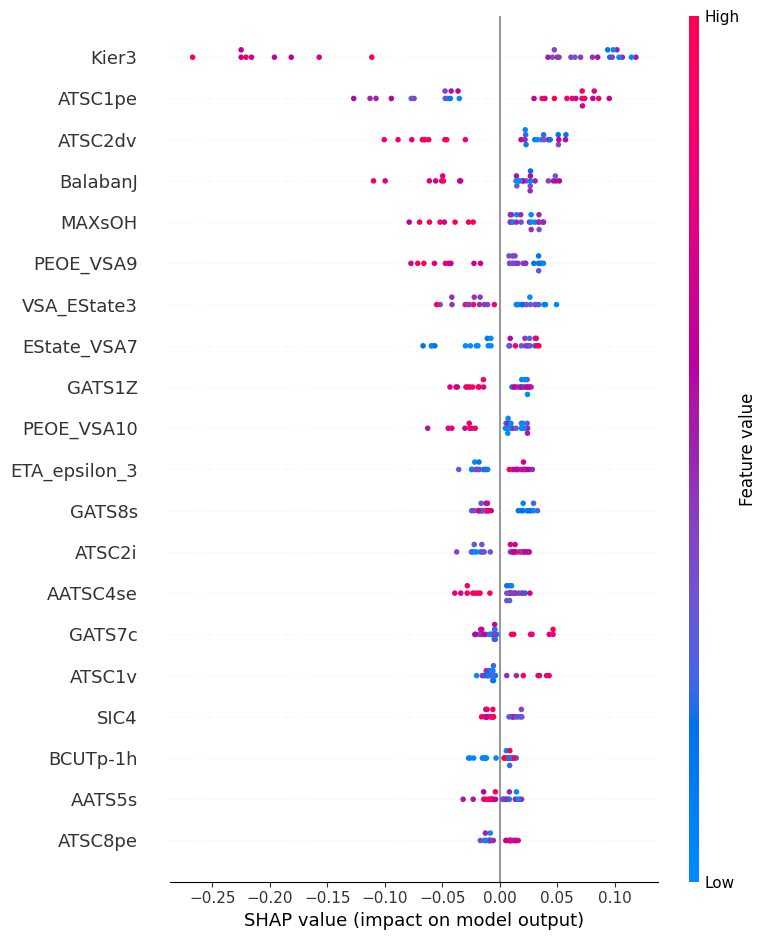

In [5]:
# SHAP features
# Prediction function for SHAP
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train, max_evals=2 * X_train.shape[1] + 20)

# Each row has values for features
shap_values = shap_result.values

# Mean absolute SHAP value per feature (importance)
shap_importance = np.abs(shap_values).mean(axis=0)
shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(ascending=False)

# XGBoost features
xgb_importance = pd.Series(base_model.feature_importances_, index=X_train.columns)
xgb_features = xgb_importance.sort_values(ascending=False)

# K-Best - Anova features
kbest = SelectKBest(score_func=f_classif, k='all')
kbest.fit(X_train, y_train)
kbest_scores = pd.Series(kbest.scores_, index=X_train.columns).fillna(0.0)
kbest_features = kbest_scores.sort_values(ascending=False)

# Lasso features
lasso = LogisticRegression(
    penalty='l1',
    C=1.0,
    solver='liblinear',
    max_iter=5000
)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# Plot
shap.summary_plot(shap_values, X_train)

## SHAP Features

In [6]:
shap_features.head(20)

Kier3            0.118855
ATSC1pe          0.066547
ATSC2dv          0.046703
BalabanJ         0.038787
MAXsOH           0.030820
PEOE_VSA9        0.030437
VSA_EState3      0.027387
EState_VSA7      0.026239
GATS1Z           0.022623
PEOE_VSA10       0.020070
ETA_epsilon_3    0.019058
GATS8s           0.018491
ATSC2i           0.018398
AATSC4se         0.016193
GATS7c           0.015229
ATSC1v           0.013490
SIC4             0.011399
BCUTp-1h         0.010970
AATS5s           0.010517
ATSC8pe          0.010258
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.607143  0.701754    0.723958
1     10     0.750000  0.800654    0.781250
2     15     0.678571  0.745098    0.744792
3     20     0.750000  0.811765    0.666667
4     25     0.750000  0.811765    0.666667

Best number of features by CV F1: 20
Top_N          20.000000
CV_Accuracy     0.750000
CV_F1           0.811765
CV_ROC_AUC      0.666667
Name: 3, dtype: float64


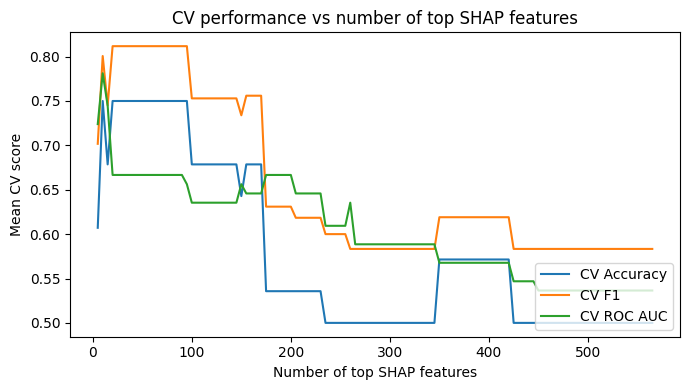

In [7]:
results = []

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(shap_features) + 1, 5):
    top_feats = shap_features.head(n).index

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["logloss", "auc"],
        random_state=42
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={
            "accuracy": "accuracy",
            "f1": "f1",
            "roc_auc": "roc_auc"
        },
        n_jobs=-1,
        return_train_score=False
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_shap = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top SHAP features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top SHAP features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## XGB Features

In [8]:
xgb_features.head(20)

PEOE_VSA9      0.125597
PEOE_VSA10     0.109923
ATSC1pe        0.100510
VSA_EState3    0.086708
AATSC4se       0.086338
GATS7c         0.080265
ATSC1v         0.064977
Kier3          0.063211
MAXsOH         0.037417
EState_VSA7    0.031244
AATS5s         0.031027
BalabanJ       0.031000
ATSC2dv        0.030297
BCUTp-1h       0.024369
SIC4           0.014483
GATS1Z         0.014433
GATS8s         0.010750
ATSC8pe        0.010082
AATS6v         0.009288
ATSC2i         0.008973
dtype: float32


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.750000  0.768908    0.812500
1     10     0.714286  0.746032    0.807292
2     15     0.750000  0.800654    0.734375
3     20     0.785714  0.844444    0.666667
4     25     0.750000  0.811765    0.666667

Best number of features by CV F1: 20
Top_N          20.000000
CV_Accuracy     0.785714
CV_F1           0.844444
CV_ROC_AUC      0.666667
Name: 3, dtype: float64


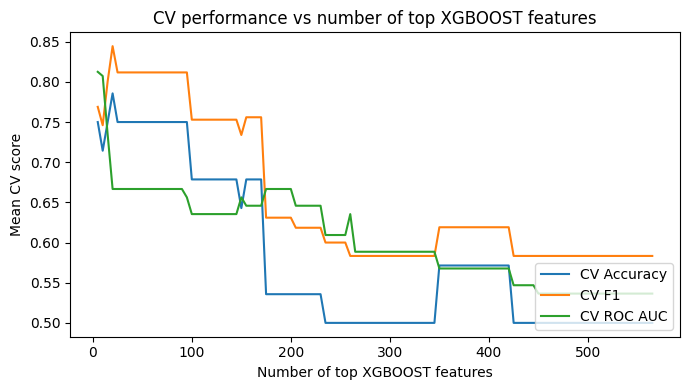

In [9]:
results = []

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(xgb_features) + 1, 5):
    top_feats = xgb_features.head(n).index

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["logloss", "auc"],
        random_state=42
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={
            "accuracy": "accuracy",
            "f1": "f1",
            "roc_auc": "roc_auc"
        },
        n_jobs=-1,
        return_train_score=False
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_xgb = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top XGBOOST features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top XGBOOST features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## KBEST Features

In [10]:
kbest_features.head(20)

PEOE_VSA9      14.363126
Kier3           8.917116
MINaaCH         8.167880
MATS3c          7.563040
MATS4s          6.986373
nG12FRing       6.914286
AETA_eta_F      6.495024
ATSC1s          6.348801
IC0             6.096723
nRot            5.906943
JGI3            5.813397
nHetero         5.806819
JGI10           5.773025
AATSC3c         5.626273
ATSC1pe         5.608532
AATS6se         5.572682
AMID_h          5.571481
AATS5se         5.482729
ETA_psi_1       5.475405
SlogP_VSA11     5.346121
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.678571  0.722222    0.640625
1     10     0.642857  0.701754    0.656250
2     15     0.642857  0.721362    0.677083
3     20     0.642857  0.721362    0.677083
4     25     0.607143  0.680921    0.640625

Best number of features by CV F1: 60
Top_N          60.000000
CV_Accuracy     0.678571
CV_F1           0.725564
CV_ROC_AUC      0.687500
Name: 11, dtype: float64


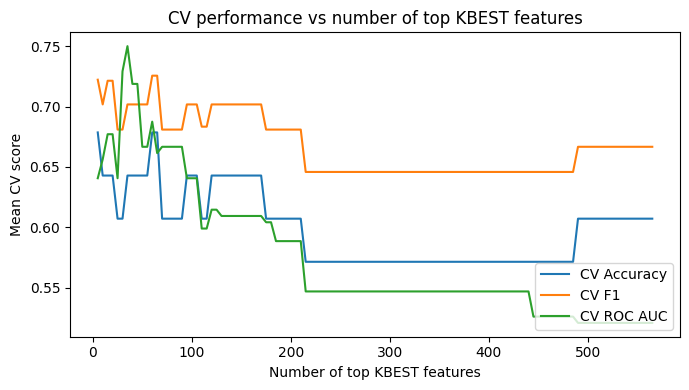

In [11]:
results = []

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(kbest_features) + 1, 5):
    top_feats = kbest_features.head(n).index

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["logloss", "auc"],
        random_state=42
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={
            "accuracy": "accuracy",
            "f1": "f1",
            "roc_auc": "roc_auc"
        },
        n_jobs=-1,
        return_train_score=False
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_kbest = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top KBEST features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top KBEST features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## LASSO Features

In [12]:
lasso_features.head(20)

EState_VSA6    0.192062
EState_VSA7    0.166051
ATSC4s         0.111883
AATS0v         0.093554
ATSC6Z         0.058770
ATSC4dv        0.034225
ATS0dv         0.031055
ATSC7Z         0.025674
ATSC4v         0.021910
ATSC2v         0.020884
ATSC7v         0.013814
ATSC3v         0.012053
ATSC8v         0.009393
ATS0Z          0.006312
ATSC6v         0.005960
ATSC8Z         0.003959
ATSC5v         0.002700
NssCH2         0.000000
NsssN          0.000000
Xc-3dv         0.000000
dtype: float64


CV results (training only, mean over folds):
   Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0      5     0.678571  0.722222    0.729167
1     10     0.642857  0.685714    0.692708
2     15     0.714286  0.775000    0.651042
3     20     0.642857  0.685714    0.651042
4     25     0.750000  0.811765    0.645833

Best number of features by CV F1: 25
Top_N          25.000000
CV_Accuracy     0.750000
CV_F1           0.811765
CV_ROC_AUC      0.645833
Name: 4, dtype: float64


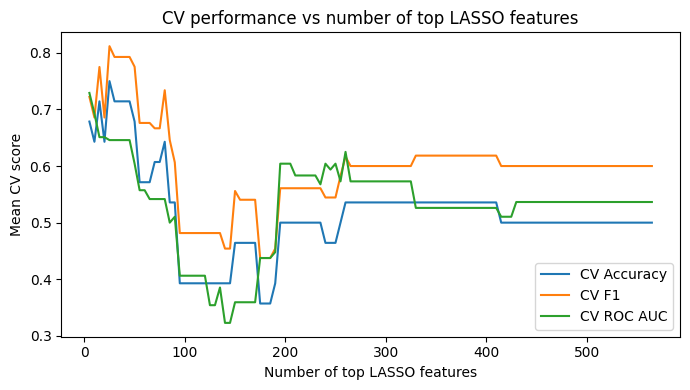

In [13]:
results = []

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Evaluate from top 5 features up to all
for n in range(5, len(lasso_features) + 1, 5):
    top_feats = lasso_features.head(n).index

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric=["logloss", "auc"],
        random_state=42
    )

    # Cross validation
    cv_res = cross_validate(
        model,
        X_train[top_feats],
        y_train,
        cv=kf,
        scoring={
            "accuracy": "accuracy",
            "f1": "f1",
            "roc_auc": "roc_auc"
        },
        n_jobs=-1,
        return_train_score=False
    )

    mean_acc = cv_res["test_accuracy"].mean()
    mean_f1 = cv_res["test_f1"].mean()
    mean_auc = cv_res["test_roc_auc"].mean()

    results.append((n, mean_acc, mean_f1, mean_auc))

# Results DataFrame
res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

# Pick best N by CV F1
best = res_df.iloc[res_df["CV_F1"].idxmax()]
best_n = int(best.Top_N)
best_n_lasso = int(best.Top_N)

print("\nCV results (training only, mean over folds):")
print(res_df.head())
print(f"\nBest number of features by CV F1: {best_n}")
print(best)

# Plot CV performance
plt.figure(figsize=(7, 4))
plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
plt.xlabel("Number of top LASSO features")
plt.ylabel("Mean CV score")
plt.title("CV performance vs number of top LASSO features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Model SHAP Features

In [14]:
top_feats = shap_features.head(best_n_shap).index.tolist()

# Train final model
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (SHAP) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (SHAP) on test:
Accuracy:  0.4286
Precision: 0.5000
Recall:    0.5000
F1 score:  0.5000
ROC AUC:   0.1667


## Model XGB Features

In [15]:
top_feats = xgb_features.head(best_n_xgb).index.tolist()

# Train final model
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (XGB) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (XGB) on test:
Accuracy:  0.0000
Precision: 0.0000
Recall:    0.0000
F1 score:  0.0000
ROC AUC:   0.0000


## Model KBEST Features

In [16]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

# Train final model
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (KBEST) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (KBEST) on test:
Accuracy:  0.1429
Precision: 0.2500
Recall:    0.2500
F1 score:  0.2500
ROC AUC:   0.0833


## Model LASSO Features

In [17]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

# Train final model
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
)

final_model.fit(X_train[top_feats], y_train)

# Evaluate
y_pred = final_model.predict(X_test[top_feats])
y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance (LASSO) on test:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Final model performance (LASSO) on test:
Accuracy:  0.2857
Precision: 0.4000
Recall:    0.5000
F1 score:  0.4444
ROC AUC:   0.1667


## Model SHAP Features Tuning

In [18]:
top_feats = shap_features.head(best_n_shap).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),

    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    **best_params
)

final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (SHAP):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Best trial: 184. Best value: 0.90625: 100%|██████████| 200/200 [00:09<00:00, 21.25it/s] 



Best trial:
  Value: 0.90625
  Params:
    n_estimators: 99
    max_depth: 6
    learning_rate: 0.05498872496456784
    subsample: 0.5817318566628996
    colsample_bytree: 0.5190669708959342
    min_child_weight: 1.1603666054522477
    gamma: 0.002971228506679413
    reg_lambda: 1.572445480772831
    reg_alpha: 0.05383168617966974

Final Optuna model (SHAP):
Accuracy:  0.2857
Precision: 0.3333
Recall:    0.2500
F1 score:  0.2857
ROC AUC:   0.1667


## Model XGB Features Tuning

In [19]:
top_feats = xgb_features.head(best_n_xgb).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    **best_params
)

final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (XGB):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Best trial: 159. Best value: 0.880208: 100%|██████████| 200/200 [00:09<00:00, 21.65it/s]


Best trial:
  Value: 0.8802083333333333
  Params:
    n_estimators: 147
    max_depth: 6
    learning_rate: 0.14210848139677687
    subsample: 0.5090687164071606
    colsample_bytree: 0.5037613923974004
    min_child_weight: 1.2337103350525072
    gamma: 0.6554840847489131
    reg_lambda: 0.2317199727546853
    reg_alpha: 0.15178426131123676

Final Optuna model (XGB):
Accuracy:  0.0000
Precision: 0.0000
Recall:    0.0000
F1 score:  0.0000
ROC AUC:   0.0000


## Model KBEST Features Tuning

In [20]:
top_feats = kbest_features.head(best_n_kbest).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    **best_params
)

final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (KBEST):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Best trial: 51. Best value: 0.8125: 100%|██████████| 200/200 [00:10<00:00, 18.56it/s] 



Best trial:
  Value: 0.8125
  Params:
    n_estimators: 69
    max_depth: 5
    learning_rate: 0.27193451751013903
    subsample: 0.6745922970588948
    colsample_bytree: 0.6098918519441238
    min_child_weight: 1.4501732156775233
    gamma: 0.17958240223171218
    reg_lambda: 1.2659438148494426
    reg_alpha: 0.0174463929272395

Final Optuna model (KBEST):
Accuracy:  0.1429
Precision: 0.2500
Recall:    0.2500
F1 score:  0.2500
ROC AUC:   0.0833


## Model LASSO Features Tuning

In [21]:
top_feats = lasso_features.head(best_n_lasso).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
    }

    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    # CV
    scores = cross_val_score(
        model,
        X_train_fs,
        y_train,
        cv=cv,
        # scoring="f1",
        scoring="roc_auc",
        n_jobs=-1
    )

    return scores.mean()

# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    **best_params
)

final_model.fit(X_train_fs, y_train)

# Evaluate
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (LASSO):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Best trial: 181. Best value: 0.765625: 100%|██████████| 200/200 [00:09<00:00, 21.26it/s]


Best trial:
  Value: 0.7656250000000001
  Params:
    n_estimators: 123
    max_depth: 7
    learning_rate: 0.08834980799456085
    subsample: 0.6833195517152709
    colsample_bytree: 0.5211765345744148
    min_child_weight: 1.0134653722787093
    gamma: 0.43118901280441696
    reg_lambda: 1.491858734775709
    reg_alpha: 1.3645569419447663

Final Optuna model (LASSO):
Accuracy:  0.4286
Precision: 0.5000
Recall:    0.5000
F1 score:  0.5000
ROC AUC:   0.1667


## Model SHAP Features Tuning + Early Stopping

In [22]:
# Feature selection
top_feats = shap_features.head(best_n_shap).index.tolist()

X_train_fs = X_train[top_feats]
X_test_fs = X_test[top_feats]

optuna.logging.set_verbosity(optuna.logging.ERROR)

# Optuna objective with CV + early stopping
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.7),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 5.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 2.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 2.0, log=True),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 10, 40),
    }

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    fold_aucs = []

    for train_idx, valid_idx in cv.split(X_train_fs, y_train):
        X_tr, X_val = X_train_fs.iloc[train_idx], X_train_fs.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = xgb.XGBClassifier(**params)

        model.fit(
            X_tr,
            y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        y_val_pred = model.predict_proba(X_val)[:, 1]
        fold_auc = roc_auc_score(y_val, y_val_pred)
        fold_aucs.append(fold_auc)

    return np.mean(fold_aucs)


# Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("\nBest trial:")
print("  Value:", study.best_value)
print("  Params:")
for k, v in study.best_params.items():
    print(f"    {k}: {v}")

# Final model
best_params = study.best_params.copy()

# Extract early_stopping_rounds from tuned params
best_esr = best_params.pop("early_stopping_rounds", 30)

final_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42,
    early_stopping_rounds=best_esr,
    **best_params
)

# Use an internal validation split for early stopping
X_tr_final, X_val_final, y_tr_final, y_val_final = train_test_split(
    X_train_fs, y_train, test_size=0.2, stratify=y_train, random_state=42
)

final_model.fit(
    X_tr_final,
    y_tr_final,
    eval_set=[(X_val_final, y_val_final)],
    verbose=False
)

# Evaluate on test set
y_pred = final_model.predict(X_test_fs)
y_prob = final_model.predict_proba(X_test_fs)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Optuna model (LASSO + CV + Early Stopping):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

Best trial: 178. Best value: 0.963542: 100%|██████████| 200/200 [00:14<00:00, 14.08it/s]



Best trial:
  Value: 0.9635416666666667
  Params:
    n_estimators: 95
    max_depth: 4
    learning_rate: 0.09412439865623974
    subsample: 0.5522301428384823
    colsample_bytree: 0.5916703855235399
    min_child_weight: 1.1793303584171275
    gamma: 0.5844761971953825
    reg_lambda: 0.39579256893337256
    reg_alpha: 0.12172823939098881
    early_stopping_rounds: 10

Final Optuna model (LASSO + CV + Early Stopping):
Accuracy:  0.5714
Precision: 0.5714
Recall:    1.0000
F1 score:  0.7273
ROC AUC:   0.2083


## Model SHAP Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 60, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Accuracy: 0.286 | ROC-AUC: 0.000

=== Testing top 6 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 80, 'max_depth': 6, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Accuracy: 0.286 | ROC-AUC: 0.167

=== Testing top 7 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.286 | ROC-AUC: 0.167

=== Testing top 8 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': 80, 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Accuracy: 0.143 | ROC-AUC: 0.000

=== Testing top 9 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': 80, 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Accuracy: 0.143 | ROC-AUC: 0.167

=== Testing top 10 features ===
Best parameters: {'subsample': 0.8, 'n_estimat

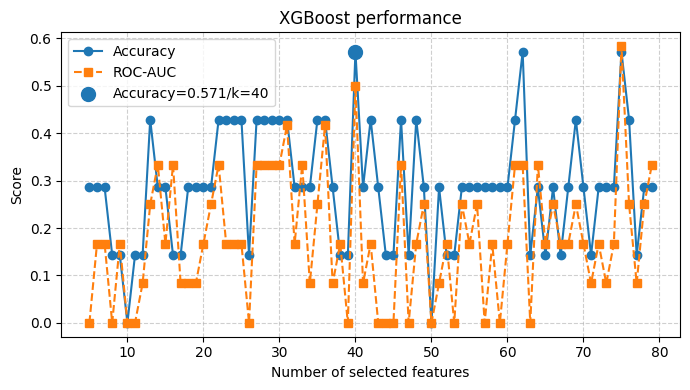


Accuracy = 0.571/ROC-AUC = 0.500/k = 40


In [23]:
ranking = shap_features

param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

results = []
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model XGB Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': 80, 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Accuracy: 0.143 | ROC-AUC: 0.250

=== Testing top 6 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 60, 'max_depth': 4, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Accuracy: 0.286 | ROC-AUC: 0.250

=== Testing top 7 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': 60, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Accuracy: 0.429 | ROC-AUC: 0.500

=== Testing top 8 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': 60, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Accuracy: 0.143 | ROC-AUC: 0.000

=== Testing top 9 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': 140, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Accuracy: 0.286 | ROC-AUC: 0.000

=== Testing top 10 features ===
Best parameters: {'subsample': 0.6, 'n_estimat

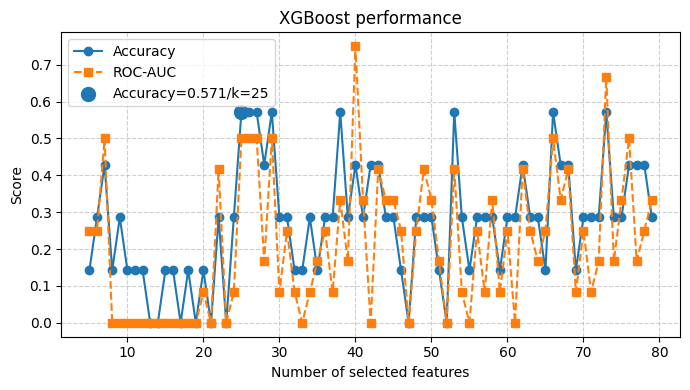


Accuracy = 0.571/ROC-AUC = 0.500/k = 25


In [24]:
ranking = xgb_features

param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

results = []
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=200,
        scoring="roc_auc",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model KBEST Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': 80, 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Accuracy: 0.143 | ROC-AUC: 0.000

=== Testing top 6 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Accuracy: 0.571 | ROC-AUC: 0.167

=== Testing top 7 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': 80, 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Accuracy: 0.143 | ROC-AUC: 0.083

=== Testing top 8 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 40, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Accuracy: 0.143 | ROC-AUC: 0.000

=== Testing top 9 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': 80, 'max_depth': 7, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Accuracy: 0.143 | ROC-AUC: 0.167

=== Testing top 10 features ===
Best parameters: {'subsample': 1.0, 'n_estimat

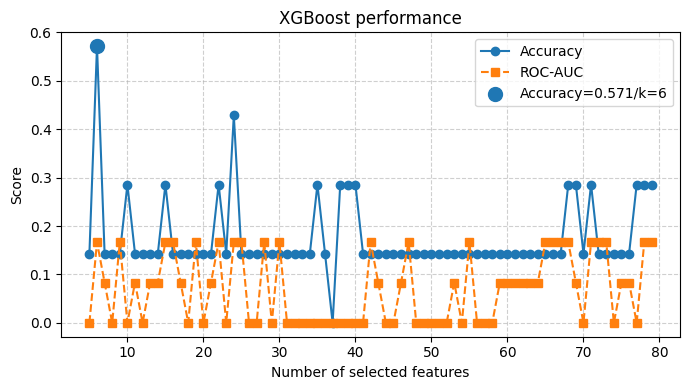


Accuracy = 0.571/ROC-AUC = 0.167/k = 6


In [25]:
ranking = kbest_features

param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

results = []
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model LASSO Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 80, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.286 | ROC-AUC: 0.417

=== Testing top 6 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 80, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Accuracy: 0.286 | ROC-AUC: 0.417

=== Testing top 7 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 80, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.286 | ROC-AUC: 0.333

=== Testing top 8 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 120, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Accuracy: 0.429 | ROC-AUC: 0.333

=== Testing top 9 features ===
Best parameters: {'subsample': 0.8, 'n_estimators': 20, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Accuracy: 0.429 | ROC-AUC: 0.250

=== Testing top 10 features ===
Best parameters: {'subsample': 0.6, 'n_est

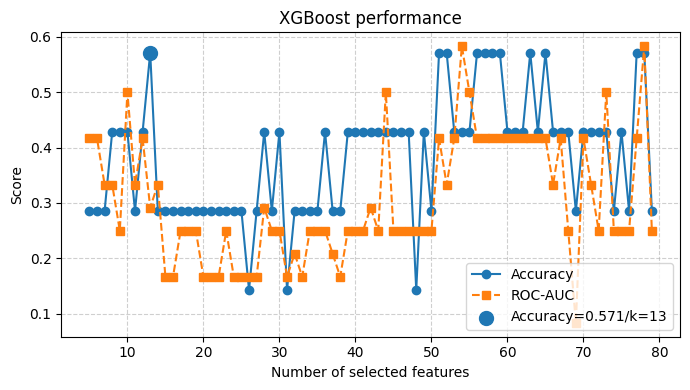


Accuracy = 0.571/ROC-AUC = 0.292/k = 13


In [26]:
ranking = lasso_features

param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

results = []
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=80,
        scoring="roc_auc",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")